## Name: Rowan Pan

## Econ 136: Return Profile and Risk of the S&P 500 Sample Work


In [1]:
import numpy as np
from scipy import stats

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style("darkgrid")


Note:  Descriptions of my coding steps are documented with # in blue

## Problem 1

1. **The return profile and risk of the S&P 500**

(a) Create a graph of the Close price of SPY (not the adjusted close price) as a function of time.  Label the axes and give it a title (e.g. SPY). This is simply a graph using the data you have downloaded.

(b) Create  a  graph  of  the  SPY  returns  as  a  function  of  time  using  the Close price and dividends.  Begin by adding a “dividends” column to assign dividends for each date. For dates with no dividends,  a  N/A  will  likely  appear.  In the next column calculate the returns including the dividends.  Graph these results.  Label the graph.

(c) Create a semi-log graph of the cumulative distribution function (CDF and 1 - CDF) of the SPY returns. Copy the values return data to the next column  using  the  “Copy”  &  “Paste  Special”  commands  so  that  on  the  return values are copied.  Order the returns using the “Sort” command.  In the column to  the  right  of  the  ordered  returns  calculate  the  CDF  using  CDF($x_k$) =k/(N+1) where k is the running index of the return k= 1...N and N is the number of returns.  The COUNT() function is useful for calculating k.  In the column to the right of your CDF results, use the IF() statement to create a column of CDF and 1-CDF depending on whether the return is negative.  Graph these results with a linear x-axis and a logarithmic y-axis.  Label the graph.

(d) Add a Gaussian distribution to the semi-log graph of the CDF of theSPY returns.Begin by calculating the mean AVERAGE() and standard devia-tion STDEV() of the ordered returns. Use them to calculate the cumulative Gaussian distribution(NORMDIST() and 1 - NORMDIST()) in the column next to your last cumula-tive distribution calculation.  Make a copy of the graph from the part (1c) above and add the cumulative Gaussian distribution to the copy.

(e) Estimate the power-law coefficients in Eq. (41) of Gabaix’s article for the SPY ETF. To do this in Excel:i.  Create the dependent variable $ln [P(|r|> x)]$ by taking the natural logarithm of your column of data containing the CDF and 1- CDF. 

ii. Create  the  independent  variable  ln (|x|)  wherexis  your  normalized  return data: $x=r−\mu_r\sigma_r$ where $\mu_r$ and $\sigma_r$ are the mean and standard deviation of the returns that you used to create your Gaussian density.

iii. Graph these results for |x| > 2 as a scatter plot.

iv. Add a add a linear trendline to the graph and (in the trendline options) show the equation of the trendline and the $R^2$ on the graph (also in the trendlineoptions).  The coefficients you seek are in the equation for the trendline.

v. Briefly discuss your value of $\xi_r$ for this ETF in terms of the result one would expect as described by Gabaix in section 6.1.1 of his paper.

# Loading the Data

In [2]:
# load spy data
spy = pd.read_csv('SPY.csv')
spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.453930,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.642057,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.698507,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.980742,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,27.093624,531500


In [3]:
# load dividends data
div = pd.read_csv('SPY_div.csv')
div.head()

,Date,Dividends
0,2011-12-16,0.770
1,2012-06-15,0.688
2,2016-09-16,1.082
3,1996-06-21,0.351
4,2017-03-17,1.033


In [4]:
spy.shape, div.shape

((6805, 7), (112, 2))

In [5]:
# I need to change the date to a more usable format for faster plotting
spy_copy = spy.copy()
spy_copy['Date'] = pd.to_datetime(spy_copy['Date'], format='%Y.%m.%d')
spy_copy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.453930,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.642057,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.698507,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.980742,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,27.093624,531500


## Part 1a

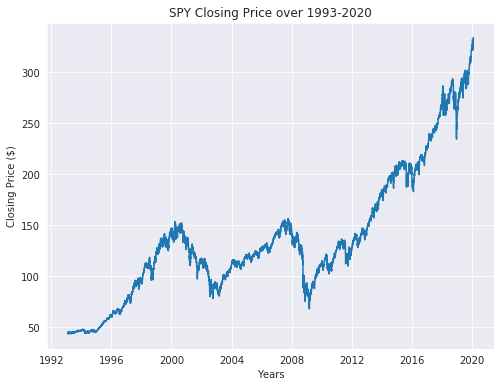

In [6]:
# plot for 1a
plt.figure(figsize = (8,6))
part_1a = plt.plot('Date', 'Close', data = spy_copy)
plt.title("SPY Closing Price over 1993-2020")
plt.xlabel("Years")
plt.ylabel("Closing Price ($)")
plt.show()

\newpage

## Part 1b

In [7]:
# merge the dividends table with the other table
spy_div = spy.merge(div, how = "outer")

# replace all N/A with 0's
spy_div['Dividends'] = spy_div['Dividends'].fillna(0)
spy_div = spy_div.drop("Adj Close", axis = 1)
spy_div.head()

,Date,Open,High,Low,Close,Volume,Dividends
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200,0.0
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,480500,0.0
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,201300,0.0
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,529400,0.0
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,531500,0.0


$\textbf{Returns Formula:}$

$$r(t) = \frac{x(t+\tau)-x(t)+\text{dividend during period}}{x(t)}$$

In [8]:
# calculate returns (return = tomorrow close - today close + dividends all divided by today close)
returns = [100*((spy_div['Close'][i+1]- spy_div['Close'][i]+ spy_div['Dividends'][i])/(spy_div['Close'][i])) 
for i in range(0, 6804)]

spy_div = spy_div.drop([6804], axis = 0)

# create new column in dataframe
spy_div['Returns'] = returns

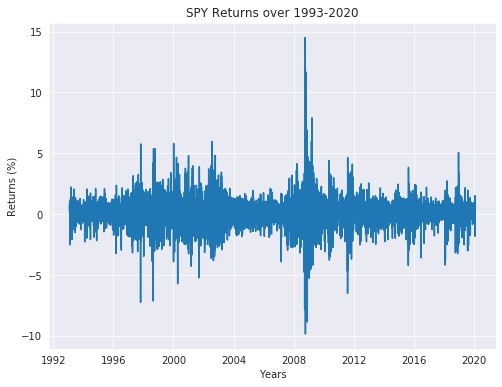

In [9]:
# plot for 1b
plt.figure(figsize = (8,6))
spy_div['Date'] = pd.to_datetime(spy_copy['Date'], format='%Y.%m.%d')

plt.plot("Date", "Returns", data = spy_div)
plt.title('SPY Returns over 1993-2020')
plt.xlabel('Years')
plt.ylabel('Returns (%)')
plt.show()

\newpage

# Part 1c

In [10]:
# sort returns and assign ascending k values 
spy_div2 = spy_div.copy()
spy_div2 = spy_div2.sort_values('Returns', ascending = True)
spy_div2['K'] = np.arange(1, len(spy_div2)+1, 1)
spy_div2[['Returns', 'K']].head()

,Returns,K
3957,-9.844768,1
3989,-8.857804,2
3945,-7.836161,3
3983,-7.423317,4
1198,-7.247340,5


In [11]:
# Let's calculate the CDF for each return
N = spy_div2.shape[0]
spy_div2['CDF'] = spy_div2['K']/(N+1)
spy_div2['Inv CDF'] = 1- spy_div2['CDF']

In [12]:
# table manipulations
spy_div2['CDF'] = (spy_div2['CDF'])
spy_div2['Inv CDF'] = (spy_div2['Inv CDF'])
spy_div2[['CDF', "Inv CDF"]].head()

,CDF,Inv CDF
3957,0.000147,0.999853
3989,0.000294,0.999706
3945,0.000441,0.999559
3983,0.000588,0.999412
1198,0.000735,0.999265


In [13]:
# This function takes in a dataframe @df. If the i'th return is negative, append the log CDF to empty array. 
# If the i'th return is positive, append the inverse log cdf to empty array.
def MergeCDF(df):
    returns = df['Returns'].tolist()
    cdf = df['CDF'].tolist()
    inv_cdf = df['Inv CDF'].tolist()
    empty = np.array([])
    
    for i in range(0, len(returns)):
        if returns[i] <0:
            empty = np.append(empty, cdf[i])
        elif returns[i]>=0:
            empty = np.append(empty, inv_cdf[i])
    return empty        

In [14]:
# show the two new columns of updated table 
combinedCDF = MergeCDF(spy_div2)
spy_div2['Combined CDF'] = combinedCDF
spy_div2[['Returns', 'Combined CDF']].head()

,Returns,Combined CDF
3957,-9.844768,0.000147
3989,-8.857804,0.000294
3945,-7.836161,0.000441
3983,-7.423317,0.000588
1198,-7.247340,0.000735


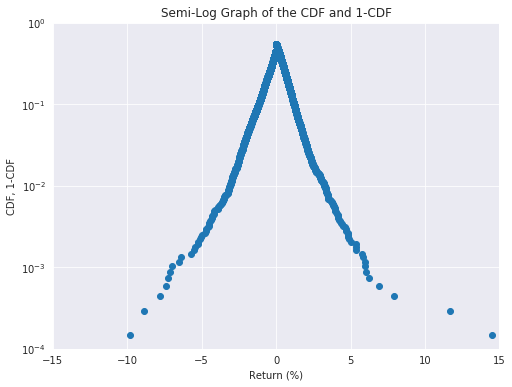

In [15]:
# here comes the plot
plt.figure(figsize = (8,6))

part_1c = plt.scatter("Returns", 'Combined CDF', data = spy_div2)
plt.title("Semi-Log Graph of the CDF and 1-CDF")
plt.xlabel('Return (%)')
plt.ylabel('CDF, 1-CDF')
plt.yscale('log')
plt.xlim(-15,15)
plt.ylim(10**-4, 1)
plt.show()

\newpage

# Part 1d

In [16]:
# calculate the mean and the standard deviation of returns
returns_mean = np.mean(spy_div2['Returns'])
returns_sd = np.std(spy_div2['Returns'])
returns_mean, returns_sd

(0.043823216552580986, 1.1443420300488205)

$\textbf{Report:}$

The $\textbf{mean}$ of the returns is $\textbf{0.0438}$ and the $\textbf{SD}$ of the returns is $\textbf{1.144}$

In [17]:
# use the normal cdf from scipy.stats
normal_returns = stats.norm.cdf(spy_div2['Returns'], returns_mean, returns_sd)
spy_div2['normal CDF'] = normal_returns
spy_div2[['normal CDF']].head()

,normal CDF
3957,2.779087e-18
3989,3.660301e-15
3945,2.868348e-12
3983,3.393976e-11
1198,9.360033e-11


In [18]:
# create new column for 1-normal CDF
spy_div2['1-normal CDF'] = 1-spy_div2['normal CDF']

In [19]:
# define new function, similar to previous function
def MergeNormal(df):
    returns = df['Returns'].tolist()
    cdf = df['normal CDF'].tolist()
    inv_cdf = df['1-normal CDF'].tolist()
    empty = np.array([])
    
    for i in range(0, len(returns)):
        if returns[i] <0:
            empty = np.append(empty, cdf[i])
        elif returns[i]>=0:
            empty = np.append(empty, inv_cdf[i])
    return empty        

In [20]:
# apply function on dataframe
normalMerged = MergeNormal(spy_div2)
spy_div2['Merged Normal'] = normalMerged
spy_div2[['normal CDF', '1-normal CDF', 'Merged Normal']].head()

,normal CDF,1-normal CDF,Merged Normal
3957,2.779087e-18,1.0,2.779087e-18
3989,3.660301e-15,1.0,3.660301e-15
3945,2.868348e-12,1.0,2.868348e-12
3983,3.393976e-11,1.0,3.393976e-11
1198,9.360033e-11,1.0,9.360033e-11


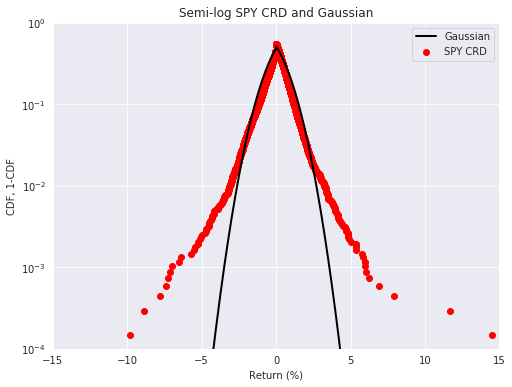

In [21]:
# here is the overlaid plot on 1d
plt.figure(figsize = (8,6))
plt.plot("Returns", 'Merged Normal', data = spy_div2, 
         label = "Gaussian", color= 'black', linewidth = 2)
plt.scatter('Returns', 'Combined CDF', data = spy_div2, 
            color = "r", label = 'SPY CRD')

plt.yscale('log')
plt.xlim(-15,15)
plt.ylim(10**-4, 1)
plt.title('Semi-log SPY CRD and Gaussian')
plt.xlabel('Return (%)')
plt.ylabel('CDF, 1-CDF')
plt.legend()
plt.show()

\newpage

# Part 1e

In [22]:
# take natural log of the log cdf and the 1-cdf (survival function)
spy_div2['Log Combined CDF'] = np.log(spy_div2['Combined CDF'])

In [23]:
# normalize returns
normed_returns = np.abs((spy_div2['Returns']- returns_mean))/returns_sd
n2 = normed_returns.copy()

spy_div_3 = spy_div2.copy()
spy_div_4 = spy_div_3[["Log Combined CDF"]]

In [24]:
# create new columns 
spy_div_4["abs_ret"] = normed_returns
spy_div_4["lnret"] = np.log(normed_returns)

# filter table for absolute normalized returns > 2
spy_div_5 = spy_div_4[spy_div_4["abs_ret"] > 2]
spy_div_5.head()

,Log Combined CDF,abs_ret,lnret
3957,-8.825413,8.641290,2.156552
3989,-8.132266,7.778817,2.051404
3945,-7.726801,6.886040,1.929496
3983,-7.439119,6.525269,1.875682
1198,-7.215975,6.371490,1.851833


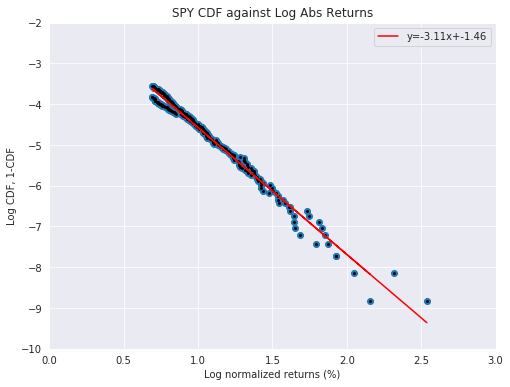

In [25]:
# here is the plot with the overlaid line
x = spy_div_5['lnret']
y = spy_div_5['Log Combined CDF']

plt.figure(figsize = (8,6))
plt.scatter(spy_div_5["lnret"], spy_div_5["Log Combined CDF"])

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.scatter(x,y, color="k", s=3.5)
plt.xlim(0,3)
plt.ylim(-10,-2)
plt.title('SPY CDF against Log Abs Returns')
plt.xlabel('Log normalized returns (%)')
plt.ylabel('Log CDF, 1-CDF')

plt.legend()
plt.show()

In [26]:
# calculate the R squared
r_value**2

0.9831399329996151

$\textbf{The equation is:}$

$\ln P(|r| > x) = -3.11 \ln(x_{SPY}) - 1.46$ 

with $R^2$ of 0.98

$\textbf{Explanation:}$ 

The $\zeta_r$ I get from the Gabaix Power law is 3.11, which is around 3, which corresponds to a finite variance in his article. It is also >2 (if $\zeta$ is around 2 Gabaix says are not Levy distributed and may have a infinite variance).

\newpage

# Problem 2

Using the data for the SPY ETF from question 1 above, if the SPY ETF has a closing price of USD 332.20:

(a)  Estimate the one-day VaR at a 97.5% confidence level.

(b)  Estimate the leverage you would offer to a client who wanted to borrow moneyto buy one SPY ETF if your firm requires the client to put up enough of theirown money to cover 98% of one-day moves in the market.  Leverage is the relative amounts of (i) the amount of asset the client can buy (i.e., the sum of the client’s money and your loan to the client), divided by (ii) the amount of money the client put up.  For example, if the client puts up 5 USD and borrows 5 USD to buy anasset that costs 10 USD then the leverage is 2:1.  Similarly, if the client put up 1USD and borrows 9 USD to buy an asset that costs 10 USD the leverage if 10:1.

## Part 2a

In [27]:
spy_div2[spy_div2['CDF'] >= 0.0249][['Returns','CDF']].head(2)

,Returns,CDF
2519,-2.370494,0.024982
3648,-2.367916,0.025129


$\textbf{Answer:}$

The One-Day VaR is related to the price change that is associated with the CDF level of $2.5 \times 10^{-2}$, which is 0.025 for confidence interval 97.5%

Above I have attached the table that gets this price change.

From the plot in 1D, the return that is around -2.367% (using confidence level of 97.5%).

Given the closing price of 332.20, the VaR would be about $332.20 \times 0.02367 = \textbf{USD 7.86}$

## Part 2b

In [28]:
# checking the LEFT side outside 98% Confidence Interval
spy_div2[spy_div2['CDF'] >= 0.01][['Returns','CDF']].head(1)

,Returns,CDF
4385,-3.08751,0.01014


In [29]:
# checking the RIGHT side outside 98% condidence Interval
spy_div2[spy_div2['CDF'] >= 0.99][['Returns','CDF']].head(1)

,Returns,CDF
1159,3.250346,0.990007


$\textbf{Answer:}$

Given we are using a 98% confidence interval, I will look at the intersection of the empirical density of 0.02 on both directions, using the CDF and 1-CDF (survival function). We are given that 98% of one-day price moves correspond to the range of returns in between the CDF of $2 \times 10^{-2}$ on both sides.

The intersection on left side correspondings to around a -3.08% and a +3.25% return on the right side. This means there is a $0.02$ probability of getting a worse than -3.08% return and a return better than +3.25%. 

In between these two returns (-3.08%, 3.25%), around 98% of the one-day moves market lie within.

We would require the client to put up $332.20 \times 0.0325 = 10.41$ dollars of his/her own money and the leverage would be $332.20:10.41$, which simplifies to $\textbf{31.9 : 1}$

\newpage

# Problem 4

4.  Federal Reserve Board Regulation T (Reg. T) allows an initial margin on stock pur-chases of 50% regardless of the volatility of the stock (i.e. 2:1 leverage).  The marginof retail accounts is typically governed by Reg. T. By contrast, the margin of professional trading accounts is generally governed by something like SPAN. You see that the hedge fund you recently joined maintains both a retail account and a professional trading account.  If your hedge fund is trying to minimize the amount of capital in themargin accounts, in which account will the low-volatility assets be kept and why?

$\textbf{Answer:}$

Between the two, I would keep the low-volatility assets in the professional trading account since the professional trading account assesses risk capital in a way that is based on the volatility of the underlying.

Now, this way of assessment based on volatility makes it possible that risk capital can be less than the 50% (2:1 leverage) required by Reg T. 

Then, the risk capital can be minimized by having these low volatility assets in a professional trading account rather than a retail account.